In [1]:
%rm -rf sample_data

In [2]:
%ls

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import torch
from torch.utils.data import Dataset

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load Datasets

In [5]:
base_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ECE697/Project/Base.csv")
#v1_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ECE697/Project/VariantI.csv")
v2_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ECE697/Project/VariantII.csv")
#v3_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ECE697/Project/VariantIII.csv")
#v4_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ECE697/Project/VariantIV.csv")
#v5_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ECE697/Project/VariantV.csv")

In [24]:
synthetic_0_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ECE697/Project/CTGAN Data/000/synthetic-dataset-000.csv", index_col=0)
synthetic_1_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ECE697/Project/CTGAN Data/001/synthetic-dataset-001.csv", index_col=0)
synthetic_2_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ECE697/Project/CTGAN Data/002/synthetic-dataset-002.csv", index_col=0)

In [25]:
synthetic_0_df = synthetic_0_df.drop(columns=["Unnamed: 0"])
synthetic_1_df = synthetic_1_df.drop(columns=["Unnamed: 0"])
synthetic_2_df = synthetic_2_df.drop(columns=["Unnamed: 0"])

In [26]:
print(len(list(synthetic_0_df)))
list(synthetic_0_df)

32


['fraud_bool',
 'income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'payment_type',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'employment_status',
 'credit_risk_score',
 'email_is_free',
 'housing_status',
 'phone_home_valid',
 'phone_mobile_valid',
 'bank_months_count',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'source',
 'session_length_in_minutes',
 'device_os',
 'keep_alive_session',
 'device_distinct_emails_8w',
 'device_fraud_count',
 'month']

# Statistical Comparisons: Median, Mean, Std

In [23]:
bd_median = base_df.median(numeric_only=True)
v2_median = v2_df.median(numeric_only=True)
sd_1_median = synthetic_1_df.median(numeric_only=True)

In [12]:
all_medians = pd.concat([bd_median, v2_median, sd_1_median], axis=1)
all_medians.columns = ["Original Base Data", "Original V2 Data", "Synthetic Data 1"]

all_medians

,Original Base Data,Original V2 Data,Synthetic Data 1
fraud_bool,0.000000,0.000000,0.000000
income,0.600000,0.600000,0.602619
name_email_similarity,0.492153,0.489745,0.493898
prev_address_months_count,-1.000000,-1.000000,-1.000000
current_address_months_count,52.000000,64.000000,63.000000
customer_age,30.000000,50.000000,40.000000
days_since_request,0.015176,0.015650,0.019954
intended_balcon_amount,-0.830507,-0.831185,-0.710637
zip_count_4w,1263.000000,1236.000000,1332.000000
velocity_6h,5319.769349,5408.425641,5571.110124


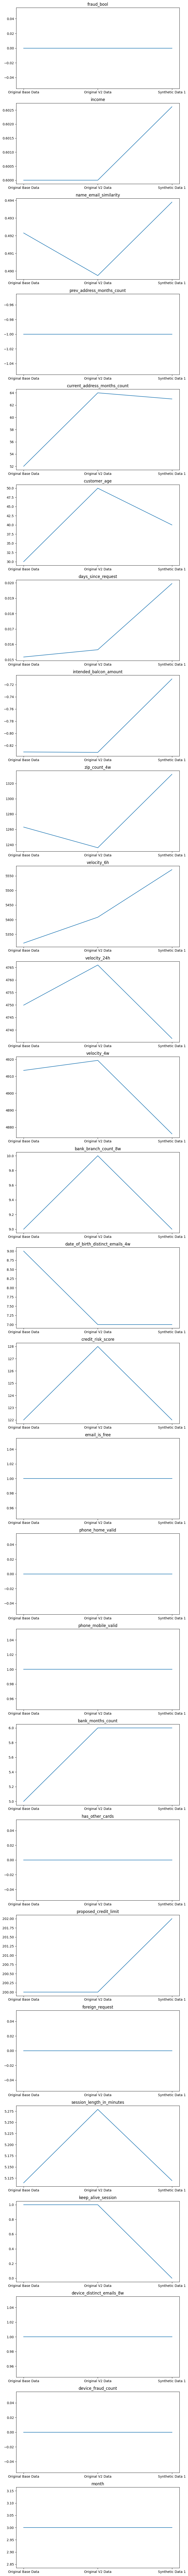

In [13]:
n_plots = all_medians.shape[0]

fig, ax = plt.subplots(n_plots, 1, figsize=(8, 4 * n_plots), tight_layout=True)

for i in range(n_plots):
    name = all_medians.iloc[i,:].name
    ax[i].plot(all_medians.iloc[i,:])
    ax[i].set_title(name)

fig.show()

In [14]:
bd_mean = base_df.mean(numeric_only=True)
v2_mean = v2_df.mean(numeric_only=True)
sd_1_mean = synthetic_1_df.mean(numeric_only=True)

In [15]:
#all_means = pd.concat([bd_mean, v124_mean, sd_0_mean, sd_1_mean, sd_2_mean], axis=1)
#all_means.columns = ["Original Base Data", "Original V124 Data", "Synthetic Data 0", "Synthetic Data 1", "Synthetic Data 2"]

all_means = pd.concat([bd_mean, v2_mean, sd_1_mean], axis=1)
all_means.columns = ["Original Base Data", "Original V1 Data", "Synthetic Data 1"]

all_means

,Original Base Data,Original V1 Data,Synthetic Data 1
fraud_bool,0.011029,0.011029,0.104200
income,0.562696,0.574544,0.561923
name_email_similarity,0.493694,0.488628,0.493147
prev_address_months_count,16.718568,14.824523,13.029630
current_address_months_count,86.587867,99.381393,99.659016
customer_age,33.689080,41.304140,38.055647
days_since_request,1.025705,0.911917,0.701664
intended_balcon_amount,8.661499,8.638806,8.046279
zip_count_4w,1572.692049,1567.400554,1601.841510
velocity_6h,5665.296605,5685.095489,5783.543150


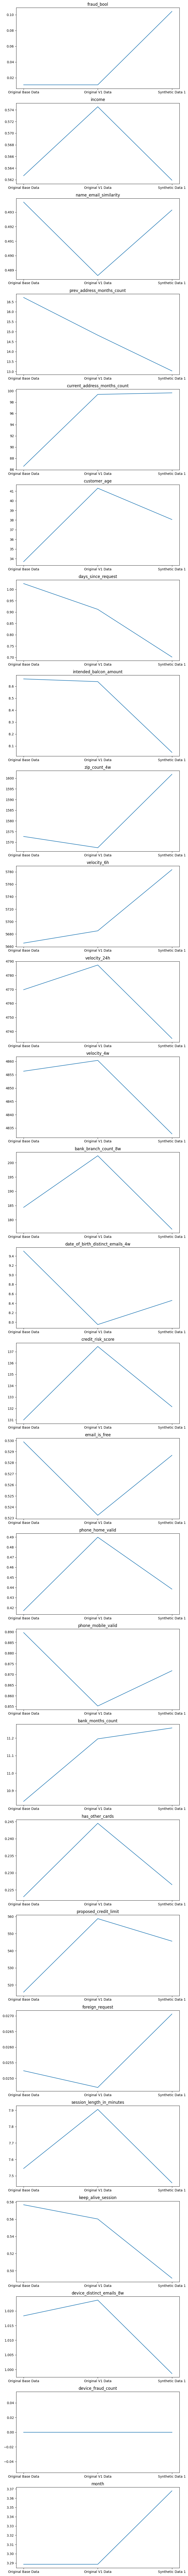

In [16]:
n_plots = all_means.shape[0]

fig, ax = plt.subplots(n_plots, 1, figsize=(8, 4 * n_plots), tight_layout=True)

for i in range(n_plots):
    name = all_means.iloc[i,:].name
    ax[i].plot(all_means.iloc[i,:])
    ax[i].set_title(name)

fig.show()

In [17]:
bd_std = base_df.std(numeric_only=True)
v2_std = v2_df.std(numeric_only=True)
sd_1_std = synthetic_1_df.std(numeric_only=True)

In [18]:
#all_stds = pd.concat([bd_std, v124_std, sd_0_std, sd_1_std, sd_2_std], axis=1)
#all_stds.columns = ["Original Base Data", "Original V124 Data", "Synthetic Data 0", "Synthetic Data 1", "Synthetic Data 2"]

all_stds = pd.concat([bd_std, v2_std, sd_1_std], axis=1)
all_stds.columns = ["Original Base Data", "Original V1 Data", "Synthetic Data 1"]

all_stds

,Original Base Data,Original V1 Data,Synthetic Data 1
fraud_bool,0.104438,0.104438,0.305520
income,0.290343,0.288768,0.293325
name_email_similarity,0.289125,0.291431,0.299330
prev_address_months_count,44.046230,43.231383,40.012915
current_address_months_count,88.406599,94.558757,96.086173
customer_age,12.025799,13.804710,13.455966
days_since_request,5.381835,4.986861,2.909790
intended_balcon_amount,20.236155,20.573558,20.113904
zip_count_4w,1005.374565,1009.619023,990.250232
velocity_6h,3009.380665,3001.707767,3227.957637


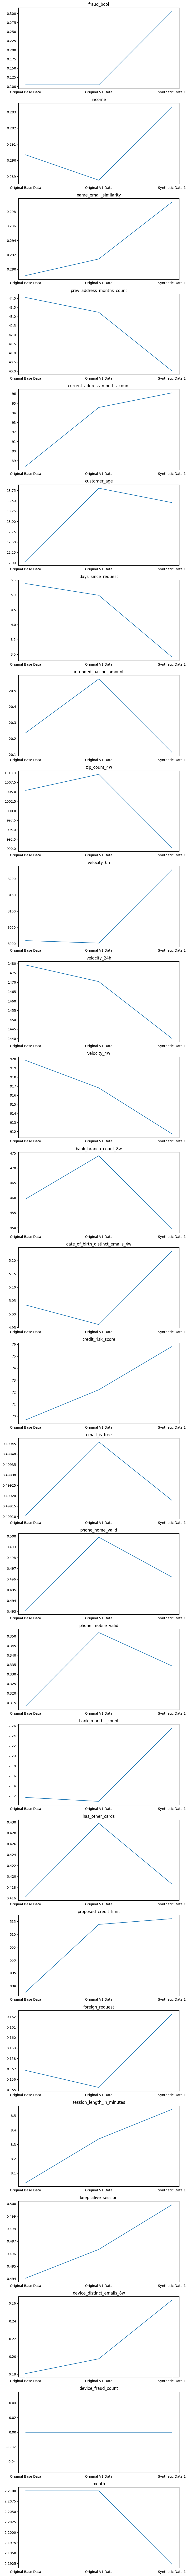

In [27]:
n_plots = all_stds.shape[0]

fig, ax = plt.subplots(n_plots, 1, figsize=(8, 4 * n_plots), tight_layout=True)

for i in range(n_plots):
    name = all_stds.iloc[i,:].name
    ax[i].plot(all_stds.iloc[i,:])
    ax[i].set_title(name)

fig.show()

# LGBM Adversarial Training

### Merge Base and V124 dataset

In [28]:
df_cols = synthetic_1_df.columns
len(df_cols)

32

In [29]:
# Declaration of categorical featuers
CATEGORICAL_FEATURES = [
    'source',
    'payment_type',
    'device_os',
    'housing_status',
    'employment_status',
    'month'
]

In [30]:
def adversarial_valid(train:pd.DataFrame, test: pd.DataFrame, columns:list, categorical_columns:list, plot_importance=True):

    # CREATE A TARGET SERIES WITH 0 VALUES CORRESPONDING TO TRAIN EXAMPLES WHEREAS VALUE 1 FOR TEST EXAMPLES
    target = np.hstack([np.zeros(train.shape[0]), np.ones(test.shape[0])])

    # Combine train and test set
    train = pd.concat([train,test],axis=0)
    train = train[columns]

    # Encode categorical columns as LGBM doesn't accept string type columns as input
    for col in categorical_columns:
        if train[col].dtype == object:
            encoder=LabelEncoder()
            train[col] = encoder.fit_transform(train[col].to_list())


    # Create a new train and test set -- Not just melb train, sydney test.
    train, test, y_train, y_test = model_selection.train_test_split(train, target, test_size=0.33, random_state=1,
                                                                    shuffle=True)

    # Convert to LGBM Dataset to prepare LGBM training
    train = lgb.Dataset(train, label=y_train, categorical_feature=categorical_columns)
    test = lgb.Dataset(test, label=y_test, categorical_feature=categorical_columns)

    # Set the parameters. -- It is a 2-class classification task so objective is binary
    param = {'objective': 'binary',
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "metric": 'auc',
             "verbosity": -1}

    # Train the classifier
    clf = lgb.train(param, train,
                    num_boost_round=200, valid_sets=[train, test],
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=50),
                      ]
                    )

    # Draw Feature importance graph

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(importance_type="gain"), clf.feature_name())), columns=['Feature Split Total Gain', 'Feature'])
    if not plot_importance:
        return clf, feature_imp
    else:
        plt.figure(figsize=(5, 5))
        sns.barplot(x="Feature Split Total Gain", y="Feature", data=feature_imp.sort_values(by="Feature Split Total Gain", ascending=False).head(100))
        plt.title('LightGBM - Feature Importance')
        plt.tight_layout()
        plt.show()

        return clf, feature_imp


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.667949	valid_1's auc: 0.665119


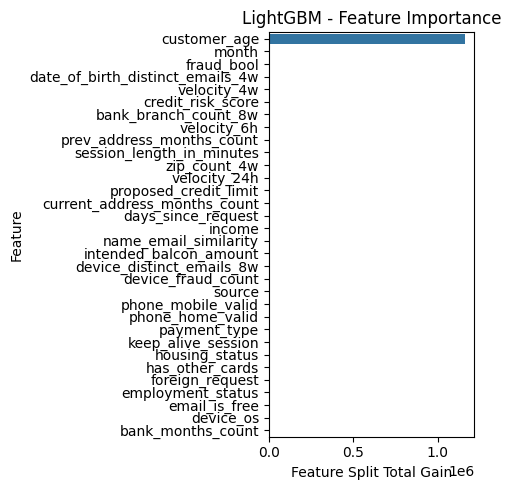

(<lightgbm.basic.Booster at 0x7b3193655480>,
     Feature Split Total Gain                           Feature
 0               0.000000e+00                 bank_months_count
 1               0.000000e+00                device_fraud_count
 2               0.000000e+00                         device_os
 3               0.000000e+00                     email_is_free
 4               0.000000e+00                 employment_status
 5               0.000000e+00                   foreign_request
 6               0.000000e+00                   has_other_cards
 7               0.000000e+00                    housing_status
 8               0.000000e+00                keep_alive_session
 9               0.000000e+00                      payment_type
 10              0.000000e+00                  phone_home_valid
 11              0.000000e+00                phone_mobile_valid
 12              0.000000e+00                            source
 13              6.763430e+00         device_distinct_email

In [31]:
adversarial_valid(base_df, v2_df, df_cols, CATEGORICAL_FEATURES, plot_importance=True)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.994256	valid_1's auc: 0.994234


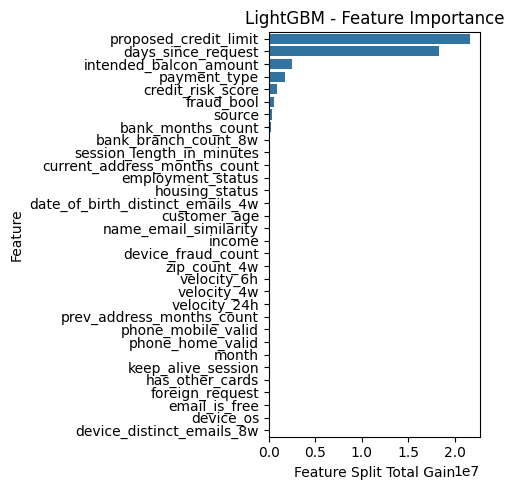

(<lightgbm.basic.Booster at 0x7b319366f310>,
     Feature Split Total Gain                           Feature
 0               0.000000e+00         device_distinct_emails_8w
 1               0.000000e+00                device_fraud_count
 2               0.000000e+00                         device_os
 3               0.000000e+00                     email_is_free
 4               0.000000e+00                   foreign_request
 5               0.000000e+00                   has_other_cards
 6               0.000000e+00                keep_alive_session
 7               0.000000e+00                             month
 8               0.000000e+00                  phone_home_valid
 9               0.000000e+00                phone_mobile_valid
 10              0.000000e+00         prev_address_months_count
 11              0.000000e+00                      velocity_24h
 12              0.000000e+00                       velocity_4w
 13              0.000000e+00                       velocit

In [32]:
adversarial_valid(base_df, synthetic_0_df, df_cols, CATEGORICAL_FEATURES, plot_importance=True)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.988796	valid_1's auc: 0.988591


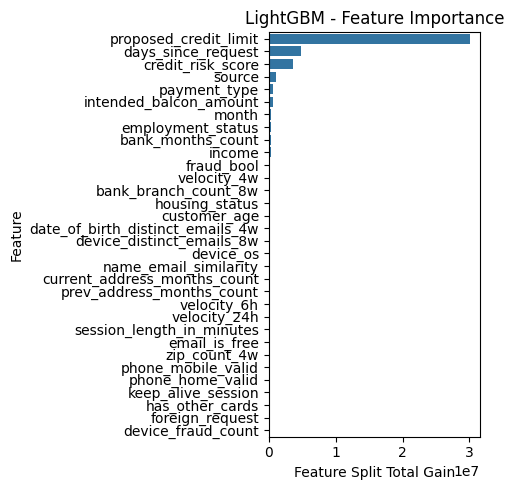

(<lightgbm.basic.Booster at 0x7b31936894e0>,
     Feature Split Total Gain                           Feature
 0               0.000000e+00                device_fraud_count
 1               0.000000e+00                     email_is_free
 2               0.000000e+00                   foreign_request
 3               0.000000e+00                   has_other_cards
 4               0.000000e+00                keep_alive_session
 5               0.000000e+00                  phone_home_valid
 6               0.000000e+00                phone_mobile_valid
 7               0.000000e+00                      zip_count_4w
 8               3.552148e+03         session_length_in_minutes
 9               3.808401e+03                      velocity_24h
 10              5.733435e+03                       velocity_6h
 11              1.305212e+04         prev_address_months_count
 12              2.444170e+04      current_address_months_count
 13              5.359534e+04             name_email_simila

In [33]:
adversarial_valid(base_df, synthetic_1_df, df_cols, CATEGORICAL_FEATURES, plot_importance=True)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999535	valid_1's auc: 0.999562


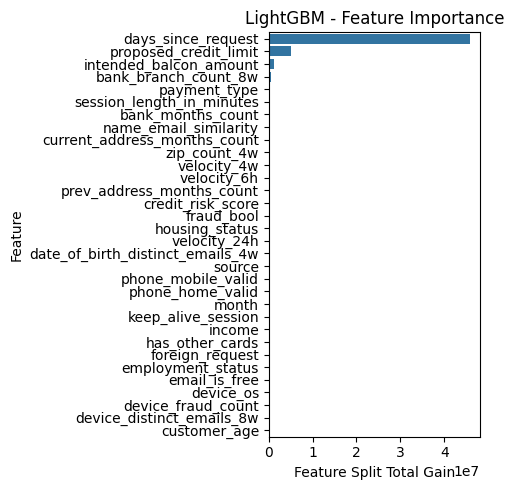

(<lightgbm.basic.Booster at 0x7b319455de70>,
     Feature Split Total Gain                           Feature
 0               0.000000e+00                      customer_age
 1               0.000000e+00  date_of_birth_distinct_emails_4w
 2               0.000000e+00         device_distinct_emails_8w
 3               0.000000e+00                device_fraud_count
 4               0.000000e+00                         device_os
 5               0.000000e+00                     email_is_free
 6               0.000000e+00                 employment_status
 7               0.000000e+00                   foreign_request
 8               0.000000e+00                   has_other_cards
 9               0.000000e+00                            income
 10              0.000000e+00                keep_alive_session
 11              0.000000e+00                             month
 12              0.000000e+00                  phone_home_valid
 13              0.000000e+00                phone_mobile_v

In [34]:
adversarial_valid(base_df, synthetic_2_df, df_cols, CATEGORICAL_FEATURES, plot_importance=True)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.994223	valid_1's auc: 0.9943


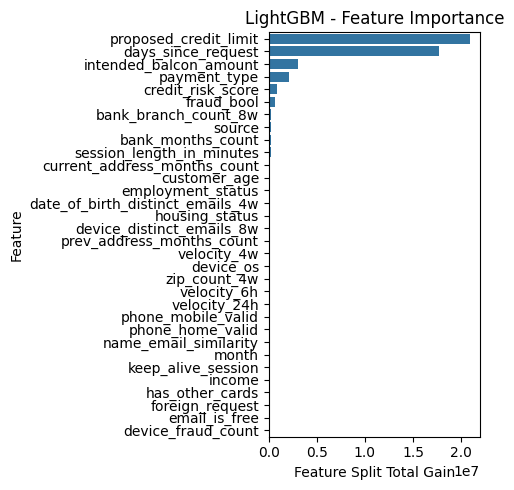

(<lightgbm.basic.Booster at 0x7b318591a0e0>,
     Feature Split Total Gain                           Feature
 0               0.000000e+00                device_fraud_count
 1               0.000000e+00                         device_os
 2               0.000000e+00                     email_is_free
 3               0.000000e+00                   foreign_request
 4               0.000000e+00                   has_other_cards
 5               0.000000e+00                            income
 6               0.000000e+00                keep_alive_session
 7               0.000000e+00                             month
 8               0.000000e+00             name_email_similarity
 9               0.000000e+00                  phone_home_valid
 10              0.000000e+00                phone_mobile_valid
 11              0.000000e+00                      velocity_24h
 12              0.000000e+00                       velocity_6h
 13              0.000000e+00                      zip_coun

In [35]:
adversarial_valid(v2_df, synthetic_0_df, df_cols, CATEGORICAL_FEATURES, plot_importance=True)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.991021	valid_1's auc: 0.990893


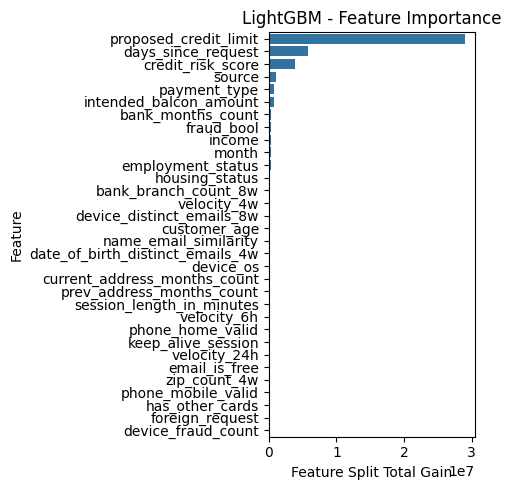

(<lightgbm.basic.Booster at 0x7b3185a3f100>,
     Feature Split Total Gain                           Feature
 0               0.000000e+00                device_fraud_count
 1               0.000000e+00                     email_is_free
 2               0.000000e+00                   foreign_request
 3               0.000000e+00                   has_other_cards
 4               0.000000e+00                phone_mobile_valid
 5               0.000000e+00                      zip_count_4w
 6               9.641960e+02                      velocity_24h
 7               1.888771e+03                keep_alive_session
 8               3.501030e+03                  phone_home_valid
 9               1.197564e+04                       velocity_6h
 10              2.138477e+04         session_length_in_minutes
 11              3.315329e+04         prev_address_months_count
 12              4.856276e+04      current_address_months_count
 13              5.845276e+04                         devic

In [36]:
adversarial_valid(v2_df, synthetic_1_df, df_cols, CATEGORICAL_FEATURES, plot_importance=True)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999573	valid_1's auc: 0.999592


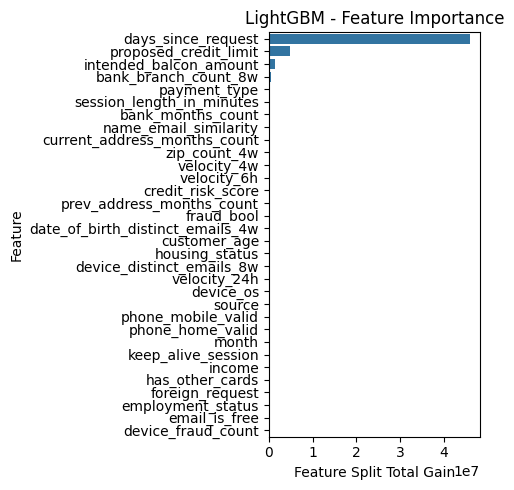

(<lightgbm.basic.Booster at 0x7b3185f5d750>,
     Feature Split Total Gain                           Feature
 0               0.000000e+00                device_fraud_count
 1               0.000000e+00                         device_os
 2               0.000000e+00                     email_is_free
 3               0.000000e+00                 employment_status
 4               0.000000e+00                   foreign_request
 5               0.000000e+00                   has_other_cards
 6               0.000000e+00                            income
 7               0.000000e+00                keep_alive_session
 8               0.000000e+00                             month
 9               0.000000e+00                  phone_home_valid
 10              0.000000e+00                phone_mobile_valid
 11              0.000000e+00                            source
 12              4.277380e+02                      velocity_24h
 13              1.265052e+03         device_distinct_email

In [37]:
adversarial_valid(v2_df, synthetic_2_df, df_cols, CATEGORICAL_FEATURES, plot_importance=True)

LGBM Adversarial Training seems to support that synthetic dataset 1 is most similar to base/v124 datasets, but discrepancies between proposed_credit_limit and days_since_request prevent it from being a better match